Note to self: For RUNNING this notebook, select the global python kernel env.

SUMMARY: This notebook finds areas where the frequency range typically making up the range of fundamental frequencies (~ 0-500 Hz) show a distinct change in power (low-high, high-low) and marks them as f0_gate_timestamps. Here, 'gate'--power gate--characterizes a similar theory to audio-gates.

At the end, one can see how these boundaries turn out on the actual spectrogram. It's best to also listen to it at these points (I did this both in PRAAT and audacity).

Prompted GPT for some of the code, since there are new tools I'm still learning to use here. All the cells, however, have also been further edited since that initial point.

In [14]:
import numpy as np
import maad
from maad import sound #, rois
# from maad.rois import find_rois_cwt
from maad.util import plot_spectrogram

### 0.
Set filepath of soundfile, .

In [15]:
filepath = '[]' #The FILEPATH for your SOUND file (expects a .wav file) 

### 1.

Initial test and graphical output.

Loading in sound file and plotting according to power.

tn=time vector (horizontal x-axis)
fn=Frequency vector (vertical y-axis)
ex=The location, in data-coordinates, of the lower-left and upper-right corners. (min, max)


<Axes: xlabel='Time [s]', ylabel='Frequency [Hz]'>

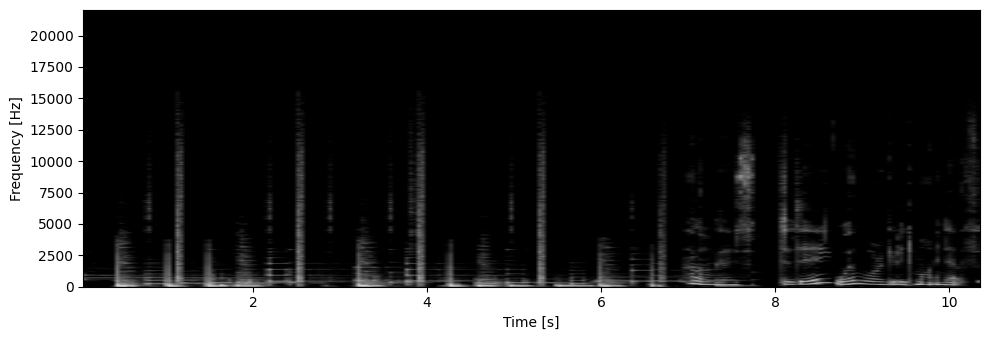

In [16]:
s, fs = sound.load(filepath)
# rois.find_rois_cwt(s, fs, flims=(4000, 8000), tlen=2, th=0, display=True)
N = 4096  # 4096 or above keeps 'energy' as significant factor
# Sxx_ampli,tn,fn,ex = maad.sound.spectrogram (s, fs, nperseg=N, noverlap=N//2, mode='amplitude')
Sxx_power, tn, fn, ex = maad.sound.spectrogram(
    s, fs, nperseg=N, noverlap=N//2, mode='psd')
# Sxx_complex,tn,fn,ex = maad.sound.spectrogram (s, fs, nperseg=N, noverlap=N//2, mode = 'complex')
# rois.find_rois_cwt(s, fs, flims=(90,13000), tlen=4, th=0, display=True)
# Sxx, tn, fn, ext = sound.spectrogram(s, fs, nperseg=1024, noverlap=512)


plot_spectrogram(Sxx_power, extent=ex, db_range=60,
                 gain=20, colorbar=False, figsize=(2.5, 10))
# print(ex[0:2]) # ex[0:2] is time-start & time-end in seconds
# print(ex[2:4]) # ex[3:4] is min-frequency & max-frequency in Hz

### 3.

If it's the first change, it won't meet the condition if it's just silence, but if it's 
speech, then it will start appending the rows and columns: the first | is thus always the first point at which speech is detected.

In [17]:
# Define frequency range for analysis
freq_min = 0
freq_max = 500

# Find indices of frequencies within the desired range
freq_indices = np.where((fn >= freq_min) & (fn <= freq_max))[0]

# Extract power values for the lower frequency range
Sxx_power_low_freq = Sxx_power[freq_indices, :]

# Define threshold for low power (can be adjusted as needed)
# Example: 1st percentile as threshold
threshold = np.percentile(Sxx_power_low_freq, 1)
# threshold = np.percentile(Sxx_power_low_freq, 5)

# Initialize lists to store row and column indices
row_indices = []
col_indices = []
# Assume non-speech is first
speechBool = False

# Loop through each element in the 2D array
for row in range(Sxx_power_low_freq.shape[0]):
    for col in range(Sxx_power_low_freq.shape[1]):
        # Check if the element is less than the threshold
        if Sxx_power_low_freq[row, col] < threshold and speechBool == True:
            # Append the row and column indices if it changed from speech to non-speech
            row_indices.append(row)
            col_indices.append(col)
            speechBool = False
            # print("above to below")
            # print(speechBool)
            # current_power_indices = (np.array(row), np.array(col))
            # low_power_timestamps = tn[current_power_indices[1]]
            # print(f"Current timestamps: {np.unique(low_power_indices)}")
        elif Sxx_power_low_freq[row, col] >= threshold and speechBool == False:
            # Append the row and column indices if it changed from speech to non-speech
            row_indices.append(row)
            col_indices.append(col)
            speechBool = True
            # print("below to above")
            # print(speechBool)
            # current_power_indices = (np.array(row), np.array(col))
            # low_power_timestamps = tn[current_power_indices[1]]
            # print(f"Current timestamps: {np.unique(low_power_indices)}")
        else:
            # print("no change")
            pass

# Convert the lists of indices to numpy arrays
row_indices = np.array(row_indices)
col_indices = np.array(col_indices)

low_power_indices = (row_indices, col_indices)

# Get the corresponding timestamps
f0_gate_timestamps = tn[low_power_indices[1]]

# Removing duplicates and sorting
f0_gate_timestamps = np.unique(f0_gate_timestamps)

# Print the results
print("Timestamps with low power in the 0-1500 Hz range:", f0_gate_timestamps)


Timestamps with low power in the 0-1500 Hz range: [0.04643991 0.09287982 0.13931973 0.18575964 0.23219955 0.27863946
 0.32507937 0.37151927 6.87310658 6.91954649 7.89478458 7.94122449
 7.9876644  8.03410431 8.08054422]


### 4.

Defines function 'filter_intervals()' so that it finds only when speech and silence change over a longer difference, time-wise.


In [18]:
def filter_intervals(boundaries, min_interval=0.3):
    """
    Filter out intervals shorter than min_interval from the boundaries.

    Parameters:
    - boundaries: 1D numpy array of boundaries.
    - min_interval: Minimum interval length to keep. (in seconds)

    Returns:
    - A 1D numpy array of filtered boundaries.
    """
    # Ensure boundaries is a numpy array
    boundaries = np.array(boundaries)

    # Compute intervals between consecutive boundaries
    intervals = np.diff(boundaries)

    # Identify the intervals to keep
    valid_intervals = intervals >= min_interval

    # To keep intervals, we need to keep the boundaries at the start and end of each valid interval
    # Start by including the first boundary
    filtered_boundaries = [boundaries[0]]

    # Iterate through intervals and add boundaries that mark valid intervals
    for i in range(len(valid_intervals)):
        if valid_intervals[i]:
            filtered_boundaries.append(boundaries[i + 1])

    # Convert to numpy array
    filtered_boundaries = np.array(filtered_boundaries)
    # filtered_boundaries_ms = filtered_boundaries * 1000

    return filtered_boundaries

### 5.
Runs 'filter_intervals()' function over f0_gate_timestamps found earlier.

In [19]:
filtered_boundaries = filter_intervals(f0_gate_timestamps, 0.3)
print(filtered_boundaries)

[0.04643991 6.87310658 7.89478458]


### 6.

Now let's see how right it looks when the boundaries are placed on the spectrogram of the sound file.

/tmp/ipykernel_37759/1793705231.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(filepath)


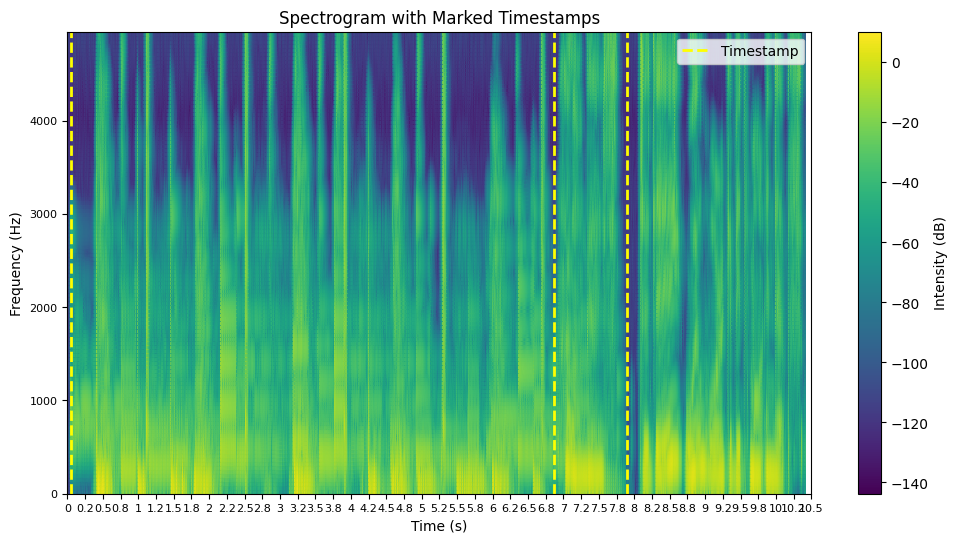

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import parselmouth
from scipy.io import wavfile

# Load the WAV file using scipy for compatibility  # Replace with your file path
fs, signal = wavfile.read(filepath)

# Create a Parselmouth Sound object
sound = parselmouth.Sound(filepath)

# Compute the spectrogram
spectrogram = sound.to_spectrogram()
#spectrogram = sound.to_formant_burg()

# Extract time and frequency values
times = spectrogram.xs()
frequencies = spectrogram.ys()
Sxx = spectrogram.values

# Define timestamps to mark (in seconds)
interval=0.25
timestamps = filtered_boundaries

# Custom formatter function
def custom_formatter(x, pos):
    if x % 1 == 0:
        return f'{int(x)}'  # Whole numbers
    else:
        return f'{x:.1f}'  # Decimal numbers

# Plots spectrogram
plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram with Marked Timestamps')

#plt.xticks(np.arange(0, np.max(times)+interval, interval))
#plt.xticks(np.arange(0, np.max(times) + interval, interval), fontsize=6)  # Adjust font size for x-axis ticks

# Sets custom formatter for both axes
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
# Tickmarks on graph, both x- and y-axes
plt.xticks(np.arange(0, np.max(times) + interval, interval), fontsize=8)  # Adjust font size for x-axis ticks
plt.yticks(fontsize=8)  # Adjust font size for y-axis ticks

# Plots lines at the specified timestamps
for timestamp in timestamps:
    plt.axvline(x=timestamp, color='yellow', linestyle='--', linewidth=2, label='Timestamp' if timestamp == timestamps[0] else "")

plt.legend()
plt.show()
